# Preparation of Final Dataset

## Import Libraries

### Main Libraries

In [1]:
import pandas as pd
import numpy as np

### Visualization Libraries

In [2]:
# Seaborn
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

### Scikit Learn

In [3]:
# Train - Test Split
from sklearn.model_selection import train_test_split
# Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Load Dataset

In [4]:
# Load fullstat dataset
df_post = pd.read_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/cleaned/fullstatCleaned_withLabels.tsv', index_col='Unnamed: 0', sep='\t')
# Load comments dataset
df_comments = pd.read_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/commentsSVM.tsv', index_col='Unnamed: 0', sep='\t')
# Load topic featurs dataset
df_topic = pd.read_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/topic_features.tsv', index_col='Unnamed: 0', sep='\t')

## Combine dataframe to create final dataframe

In [5]:
# Aggregate post_id by sentiments
post_sentiment = pd.crosstab(df_comments.post_id, df_comments.sentiments)
post_sentiment = post_sentiment.reset_index()

In [6]:
# Concatenate df_topic and df_post
df_final = pd.concat([df_post, df_topic], axis=1)

In [7]:
# Merge df_final and post_sentiment. To include number of sentiments in dataframe
df_final = pd.merge(df_final, post_sentiment, how='outer', on='post_id')

## Data Pre-processing

In [8]:
# Drop unnecessary columns
drop_col = ['by', 'comment_likes_count', 'comments_base', 'comments_replies',
            'comments_retrieved','engagement_fb', 'post_id', 'post_message',
            'rea_ANGRY', 'rea_HAHA', 'rea_LOVE', 'rea_SAD', 'rea_THANKFUL', 'rea_WOW']

df_final = df_final.drop(drop_col, axis=1)

In [9]:
# Fill NA with 0
fill_NA = ['Negative', 'Neutral', 'Positive']

for col in fill_NA:
    df_final[col].fillna(0, inplace=True)

In [10]:
# Convert post_publish to datetime data type
df_final['post_published'] = pd.to_datetime(df_final['post_published'])
# Get hour of the day
df_final['hour_day'] = df_final['post_published'].dt.hour

In [11]:
# Get total of reactions (reactions_count_fb = totalReactions - totalLikes)
df_final['reactions_count_fb'] = df_final['reactions_count_fb'] - df_final['likes_count_fb']

In [12]:
# Add dummy variables
catColumns_dummy = ['category', 'type']

for col in catColumns_dummy:
    add_dummy = pd.get_dummies(df_final[col])
    df_final = pd.concat([df_final, add_dummy], axis ='columns')

In [13]:
# Compute for engagement score = likes + (5*reactions) + (20*comments) + (30*shares)
likes = df_final['likes_count_fb']
reactions = df_final['reactions_count_fb']
comments = df_final['comments_count_fb']
shares = df_final['shares_count_fb']

df_final['engagement_score'] = likes + (5*reactions) + (20*comments) + (30*shares)

In [14]:
# Drop unnecessary columns
drop_col = ['category', 'type', 'post_published', 'likes_count_fb',
           'reactions_count_fb', 'comments_count_fb', 'shares_count_fb']

# Drop post_published
df_final = df_final.drop(drop_col, axis=1)

In [15]:
# Convert columns to float
col_df = list(df_final.columns)

for col in col_df:
    df_final[col] = df_final[col].astype(float)

In [16]:
df_final.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Positive,hour_day,App Update,Engagement,Promo,link,photo,status,video,engagement_score
0,0.016667,0.016667,0.601591,0.016667,0.265269,0.016667,0.016668,0.016668,0.016668,0.016668,...,0.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,231.0
1,0.699907,0.033349,0.033340,0.033338,0.033356,0.033345,0.033342,0.033342,0.033339,0.033343,...,0.0,14.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,820.0
2,0.774977,0.025003,0.025002,0.025000,0.025001,0.025000,0.025009,0.025003,0.025001,0.025003,...,0.0,15.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,230.0
3,0.025010,0.025006,0.025004,0.025001,0.025005,0.025007,0.774959,0.025002,0.025002,0.025005,...,0.0,14.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,213.0
4,0.887463,0.012505,0.012502,0.012511,0.012505,0.012502,0.012502,0.012502,0.012503,0.012504,...,0.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,181.0


### Split Train - Test Dataset

In [17]:
# Separate features and target (engagement_score, positive, negative, neutral)
X = df_final.drop(['engagement_score', 'Positive', 'Negative', 'Neutral'], axis=1)
y = df_final.loc[:, ['engagement_score', 'Positive', 'Negative', 'Neutral']]

In [18]:
# Columns that will be scaled using StandardScaler
standard_col = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 
                'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 
                'Topic 8', 'Topic 9']
# Column that will be scaled using MinMaxScaler; MinMaxScaler because the data is ordinal
minMax_col = ['hour_day']

# Category columns
cat_col = ['App Update', 'Engagement', 'Promo',
          'link', 'photo', 'status', 'video']

In [19]:
# Split dataset into Train (80%) - Test (20%) Dataset ; random_state = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Split dataset into Train (80%) - Test (20%) Dataset ; random_state = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Print shape of the train - test datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((781, 18), (781, 4), (196, 18), (196, 4))

In [20]:
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [21]:
# For StandardScaler
X_train_std = X_train[standard_col]
X_test_std = X_test[standard_col]

# For MinMaxScaler
X_train_minMax = X_train[minMax_col]
X_test_minMax = X_test[minMax_col]

# Category columns
X_train_cat = X_train[cat_col]
X_test_cat = X_test[cat_col]

### StandardScaler

In [22]:
# Standardize
SScaler = StandardScaler()

#Fit the scaler to the training set (continuous columns)
SScaler.fit(X_train_std)

#Transform the training set
X_train_std = pd.DataFrame(SScaler.transform(X_train_std), columns = standard_col)

#Transform the test set
X_test_std = pd.DataFrame(SScaler.transform(X_test_std), columns = standard_col)

### MinMaxScaler

In [23]:
# Standardize
MMScaler = MinMaxScaler()

#Fit the scaler to the training set (continuous columns)
MMScaler.fit(X_train_minMax)

#Transform the training set
X_train_minMax = pd.DataFrame(MMScaler.transform(X_train_minMax), columns = minMax_col)

#Transform the test set
X_test_minMax = pd.DataFrame(MMScaler.transform(X_test_minMax), columns = minMax_col)

#### Dataset for EngagementScore

In [24]:
# Scaled training dataset
df_train_eng = pd.concat([X_train_std, X_train_minMax, X_train_cat, y_train['engagement_score']], axis=1)
# Scaled testing dataset
df_test_eng = pd.concat([X_test_std, X_test_minMax, X_test_cat, y_test['engagement_score']], axis=1)
# Concat df_train, df_test
df_finalEngagement_scaled = pd.concat([df_train_eng, df_test_eng], ignore_index=True)

#### Dataset for Sentiment Classification

In [25]:
# Scaled training dataset
df_train_senti = pd.concat([X_train_std, X_train_minMax, X_train_cat, y_train[['Positive', 'Neutral', 'Negative']]], axis=1)
# Scaled testing dataset
df_test_senti = pd.concat([X_test_std, X_test_minMax, X_test_cat, y_test[['Positive', 'Neutral', 'Negative']]], axis=1)
# Concat df_train, df_test
df_finalSenti_scaled = pd.concat([df_train_senti, df_test_senti], ignore_index=True)

In [26]:
# Set conditions
conditions = [(df_finalSenti_scaled['Positive'] > df_finalSenti_scaled['Negative']) & (df_finalSenti_scaled['Positive'] >= df_finalSenti_scaled['Neutral']),
              (df_finalSenti_scaled['Negative'] > df_finalSenti_scaled['Positive']) & (df_finalSenti_scaled['Negative'] >= df_finalSenti_scaled['Neutral']),
              (df_finalSenti_scaled['Neutral'] > df_finalSenti_scaled['Positive']) & (df_finalSenti_scaled['Neutral'] > df_finalSenti_scaled['Negative'])]
# Set outcome of the conditions
choices = ['Positive', 'Negative', 'Neutral']
# Transform columns Positive, Neutral, Negative to one column; if Positive
df_finalSenti_scaled['sentiment_class'] = np.select(conditions, choices, default='Neutral')
# Drop Positive, Neutral, Negative
df_finalSenti_scaled = df_finalSenti_scaled.drop(['Positive', 'Negative', 'Neutral'], axis=1)

## Save as:

- df_finalEnggament_scaled.tsv
- postEngagement_train.tsv
- postEngagement_test.tsv
- df_finalSenti_scaled.tsv
- postSenti_train.tsv
- postSenti_test.tsv

In [27]:
df_finalEngagement_scaled.to_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/df_finalEngagement_scaled.tsv', sep='\t')

In [28]:
df_train_eng.to_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/postEngagement_train.tsv', sep='\t')

In [29]:
df_test_eng.to_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/postEngagement_test.tsv', sep='\t')

In [30]:
df_finalSenti_scaled.to_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/df_finalSenti_scaled.tsv', sep='\t')

In [31]:
df_train_senti.to_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/postSenti_train.tsv', sep='\t')

In [32]:
df_test_senti.to_csv('C:/Users/cherryb/Desktop/Personal Projects/Datasets/Telus - Fintech/results/postSenti_test.tsv', sep='\t')

## EDA

In [33]:
corr = df_finalEngagement_scaled.corr()

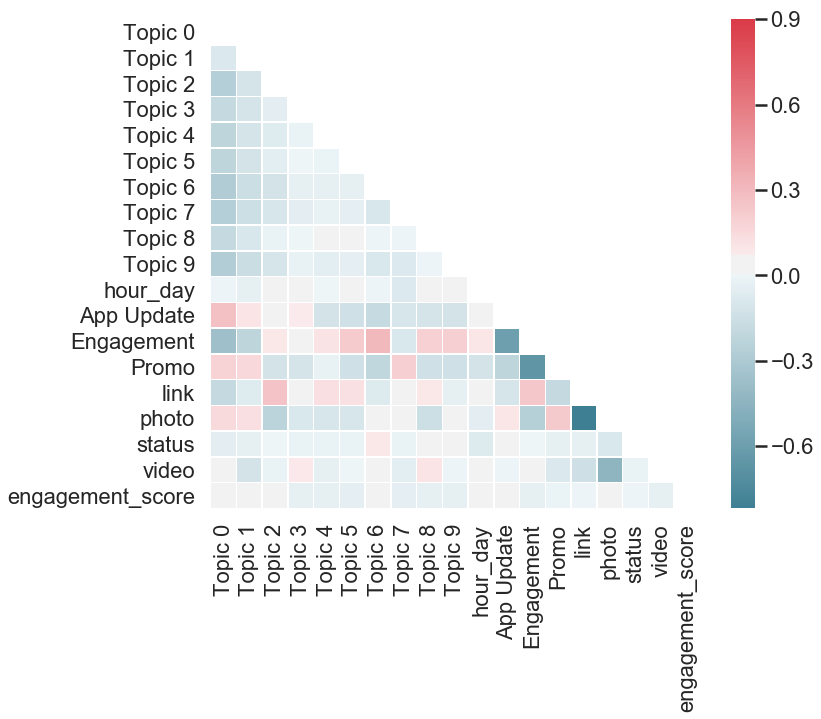

In [34]:
#Visualize Correlation

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, square=True, linewidths=.5, ax=ax, xticklabels=True, yticklabels=True)

Distributions of first 18 columns


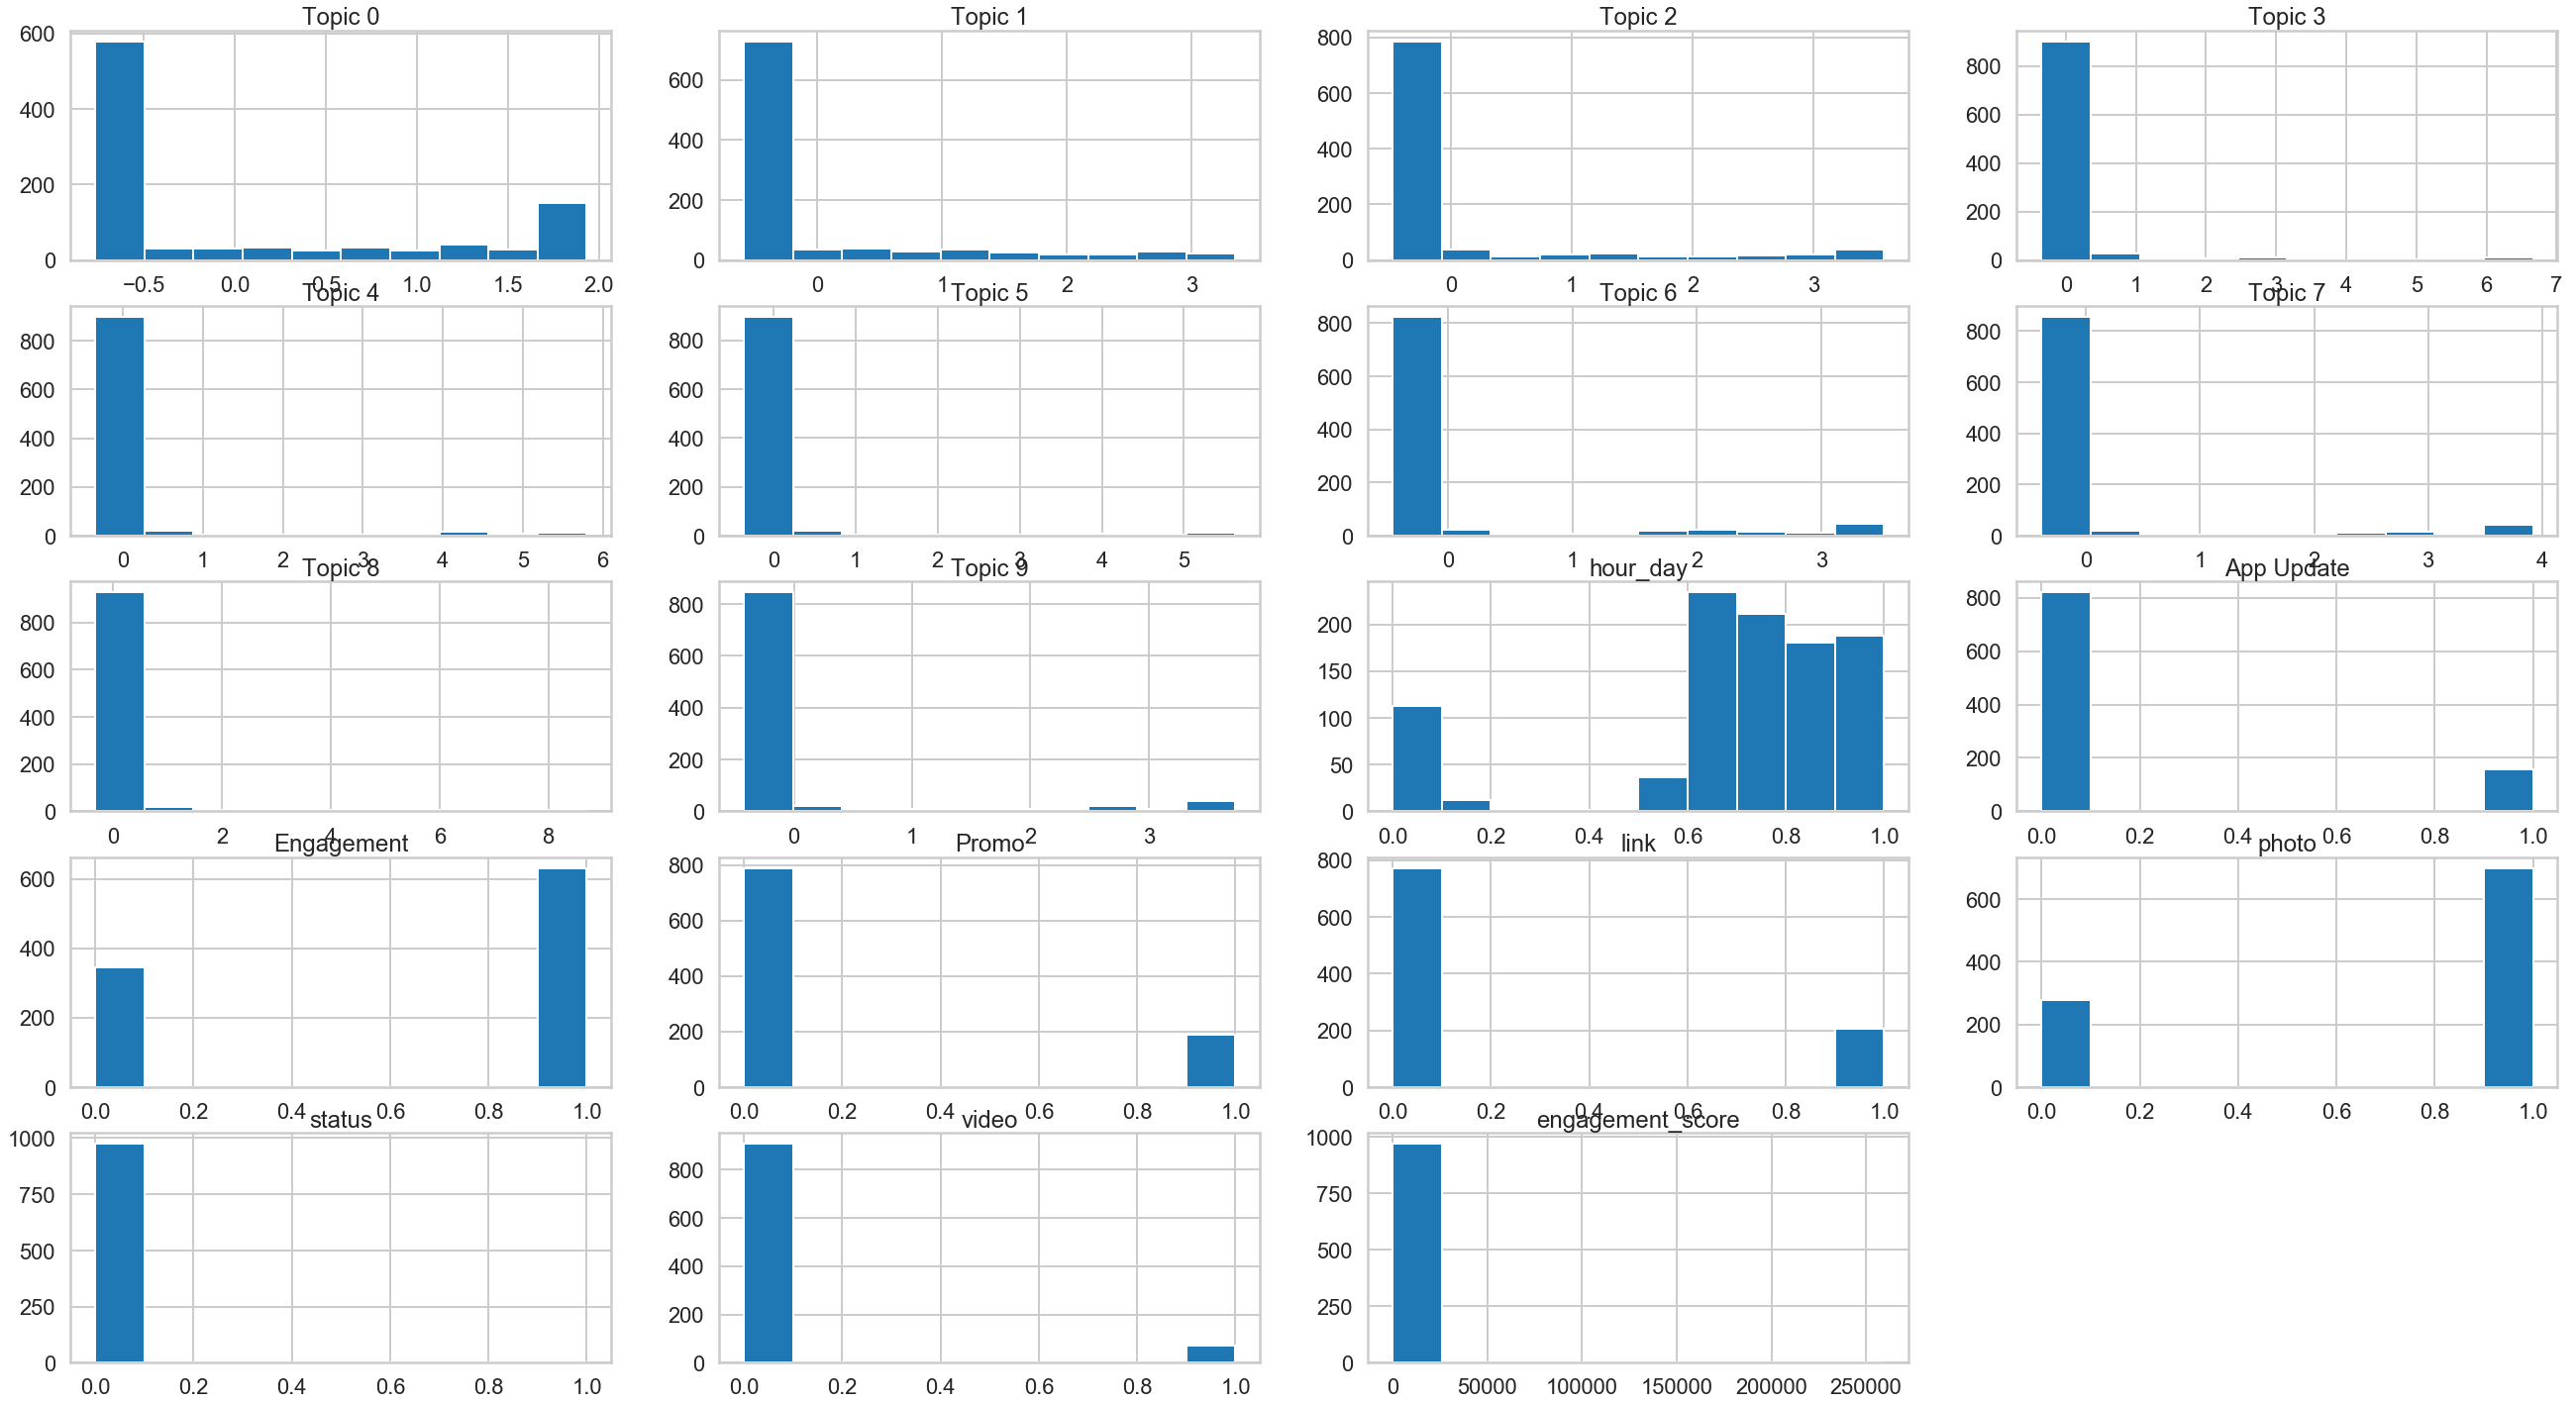

In [35]:
# Plot Distribution
print('Distributions of first 18 columns')
plt.figure(figsize=(45, 35))
for i, col in enumerate(list(df_finalEngagement_scaled.columns)):
    plt.subplot(7, 4, i + 1)
    plt.hist(df_finalEngagement_scaled[col])
    plt.title(col)